In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL

In [2]:
def graficar(s: pd.Series, t, resc = None, linea_cero=False):
    fig, ax = plt.subplots(figsize=[8,4])
    s.plot(ax=ax)
    ax.set_title(t)
    if resc is not None:        
        y1, y2 = ax.get_ylim()
        resc1 = resc == 1
        ax.fill_between(resc1.index, y1=y1, y2=y2, where=resc1, facecolor='grey', alpha=0.4)
    if linea_cero:
        ax.axhline(y=0,color='grey',linestyle='--')

def graficar2(s1: pd.Series, t1,s2: pd.Series, t2, linea_cero=False):
    fig, ax = plt.subplots(1,2,figsize=[10,4])
    s1.plot(ax=ax[0])
    s2.plot(ax=ax[1])
    ax[0].set_title(t1)
    ax[1].set_title(t2)
    if linea_cero:
        ax[0].axhline(y=0,color='grey',linestyle='--')
        ax[1].axhline(y=0,color='grey',linestyle='--')

def graficar_multiple(df):
    for col in df.columns:
        if col == 'Class':
            graficar(df[col], col)
            continue
        graficar(df[col],col,resc=df['Class'])

# Carga de datos
Se extrayeron los datos de [Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/tags/series?t=monthly)

Indicadores Macroeconómicos

In [3]:
df = pd.read_csv('../data/USA_DATA.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')
df['NBER'] = df['NBER'].astype('int')
df = df.rename(columns={'NBER':'Class'})
df.head()

,CPIAUCNS,FEDFUNDS,INDPRO,MPRIME,PAYEMS,TOTALSA,UNRATENSA,Class
DATE,,,,,,,,
1976-11-01,58.0,4.95,45.3540,6.50,80240.0,13.332,7.4,0
1976-12-01,58.2,4.65,45.8357,6.35,80448.0,14.527,7.4,0
1977-01-01,58.5,4.61,45.5276,6.25,80690.0,14.396,8.3,0
1977-02-01,59.1,4.68,46.2567,6.25,80988.0,14.709,8.5,0
1977-03-01,59.5,4.69,46.8356,6.25,81391.0,15.170,7.9,0


# Descripción

Características de dataset de macroeconomia

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 553 entries, 1976-11-01 to 2022-11-01
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   CPIAUCNS   553 non-null    float64
 1   FEDFUNDS   553 non-null    float64
 2   INDPRO     553 non-null    float64
 3   MPRIME     553 non-null    float64
 4   PAYEMS     553 non-null    float64
 5   TOTALSA    553 non-null    float64
 6   UNRATENSA  553 non-null    float64
 7   Class      553 non-null    int32  
dtypes: float64(7), int32(1)
memory usage: 36.7 KB


Metadatos del dataset

In [5]:
md = pd.read_csv('../data/USA_METADATA.csv')
md

,Feature,Description,Unit
0,CPIAUCNS,Consumer Price Index for All Urban Consumers: ...,"Index 1982-1984=100, Not Seasonally Adjusted"
1,FEDFUNDS,Federal Funds Effective Rate,"Percent, Not Seasonally Adjusted"
2,INDPRO,Industrial Production: Total Index,"Index 2017=100, Seasonally Adjusted"
3,MPRIME,Bank Prime Loan Rate,"Percent, Not Seasonally Adjusted"
4,PAYEMS,"All Employees, Total Nonfarm","Thousands of Persons, Seasonally Adjusted"
5,TOTALSA,Total Vehicle Sales,"Millions of Units, Seasonally Adjusted Annual ..."
6,UNRATENSA,Unemployment Rate,"Percent, Not Seasonally Adjusted"
7,NBER,NBER based Recession Indicators for the United...,"+1 or 0, Not Seasonally Adjusted"


Estadisticas descriptivas del dataset

In [6]:
df.describe()

,CPIAUCNS,FEDFUNDS,INDPRO,MPRIME,PAYEMS,TOTALSA,UNRATENSA,Class
count,553.000000,553.000000,553.000000,553.000000,553.000000,553.000000,553.000000,553.000000
mean,170.529465,4.644774,79.158300,7.291863,120970.696203,15.166392,6.184448,0.115732
std,60.791453,4.072702,19.869044,3.657516,20144.376327,2.273287,1.758471,0.320193
min,58.000000,0.050000,45.354000,3.250000,80240.000000,8.923000,3.300000,0.000000
25%,117.500000,1.010000,60.779000,4.000000,104962.000000,13.798000,4.900000,0.000000
50%,168.300000,4.680000,87.548800,7.250000,129788.000000,15.452000,5.900000,0.000000
75%,225.672000,6.790000,98.199000,9.000000,136325.000000,16.960000,7.200000,0.000000
max,298.012000,19.100000,104.812900,20.500000,153548.000000,22.055000,14.400000,1.000000


# Preprocesamiento

## Ajuste Estacional

Segun lo anterior, se observa que presentan estacionalidad.
Se procede a realizar un ajuste estacional, descomponiendo la serie y eliminando 
su componente de estacionalidad.

In [7]:
for col in df.columns:
    if col == 'Class':
        continue
    res = STL(df[col], period = 12).fit()
    df[col] = res.trend

## Transformaciones

Se transforma las series a variaciones segun la observacion anterior usando diferencia logaritmica

In [8]:
df_diff = df.copy()
for col in df_diff.columns:
    if col == 'Class':
        continue
    df_diff[col] = np.log(df_diff[col]) - np.log(df_diff[col].shift(1))
df_diff = df_diff.dropna()
df_diff['UNRATENSA'] = -df_diff['UNRATENSA']

# Seleccion de Caracteristicas

In [9]:
corr = df_diff.corr()
corr.style.background_gradient(cmap='coolwarm')

,CPIAUCNS,FEDFUNDS,INDPRO,MPRIME,PAYEMS,TOTALSA,UNRATENSA,Class
CPIAUCNS,1.000000,0.305262,0.113453,0.455866,0.305432,-0.293742,0.123658,0.065572
FEDFUNDS,0.305262,1.000000,0.415267,0.717162,0.614866,0.094874,0.573803,-0.374604
INDPRO,0.113453,0.415267,1.000000,0.554419,0.771877,0.624197,0.760873,-0.647641
MPRIME,0.455866,0.717162,0.554419,1.000000,0.682305,0.155190,0.630201,-0.497134
PAYEMS,0.305432,0.614866,0.771877,0.682305,1.000000,0.393952,0.869917,-0.562051
TOTALSA,-0.293742,0.094874,0.624197,0.155190,0.393952,1.000000,0.505646,-0.431677
UNRATENSA,0.123658,0.573803,0.760873,0.630201,0.869917,0.505646,1.000000,-0.550546
Class,0.065572,-0.374604,-0.647641,-0.497134,-0.562051,-0.431677,-0.550546,1.000000


In [10]:
def features_sel(corr: pd.DataFrame, n_sel):
    cc = corr['Class'].abs().sort_values(ascending=False).drop('Class')
    cc = cc.index.to_list()
    i = 0
    sel = []
    #print(cc)
    while i < n_sel:
        f = cc[0]
        #elimina alto correlacionados
        cc = [e for e in cc if e not in corr[(corr[f].abs()>0.9)].index.to_list()]
        sel.append(f)
        i += 1
    sel.append('Class')
    return sel

In [11]:
df_diff_sel = df_diff[features_sel(corr,5)]
corr2 = df_diff_sel.corr()
corr2.style.background_gradient(cmap='coolwarm')

,INDPRO,PAYEMS,UNRATENSA,MPRIME,TOTALSA,Class
INDPRO,1.000000,0.771877,0.760873,0.554419,0.624197,-0.647641
PAYEMS,0.771877,1.000000,0.869917,0.682305,0.393952,-0.562051
UNRATENSA,0.760873,0.869917,1.000000,0.630201,0.505646,-0.550546
MPRIME,0.554419,0.682305,0.630201,1.000000,0.155190,-0.497134
TOTALSA,0.624197,0.393952,0.505646,0.155190,1.000000,-0.431677
Class,-0.647641,-0.562051,-0.550546,-0.497134,-0.431677,1.000000


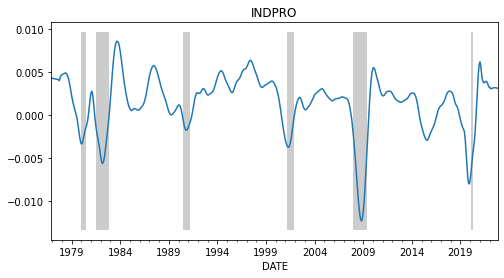

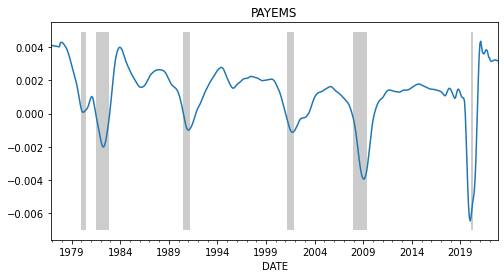

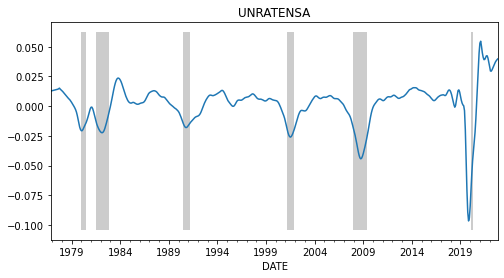

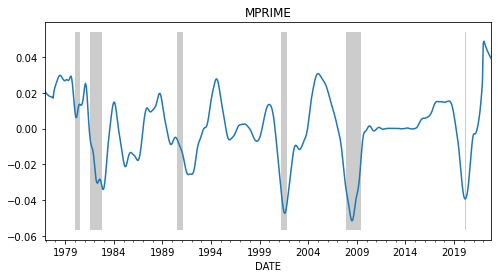

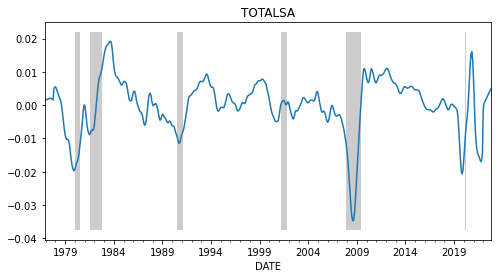

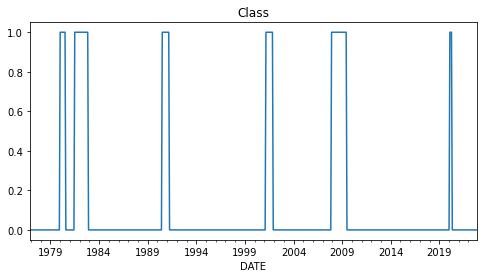

In [12]:
graficar_multiple(df_diff_sel)

Completar datos interpolando

In [13]:
df_diff_sel.head()

,INDPRO,PAYEMS,UNRATENSA,MPRIME,TOTALSA,Class
DATE,,,,,,
1976-12-01,0.004353,0.004096,0.012850,0.020660,0.001506,0
1977-01-01,0.004318,0.004089,0.013024,0.020079,0.001554,0
1977-02-01,0.004290,0.004083,0.013187,0.019538,0.001644,0
1977-03-01,0.004267,0.004076,0.013338,0.019047,0.001756,0
1977-04-01,0.004248,0.004070,0.013488,0.018619,0.001867,0


In [14]:
df_diff_sel.describe()

,INDPRO,PAYEMS,UNRATENSA,MPRIME,TOTALSA,Class
count,552.000000,552.000000,552.000000,552.000000,5.520000e+02,552.000000
mean,0.001504,0.001188,0.001758,-0.000092,-6.503275e-07,0.115942
std,0.003272,0.001763,0.017313,0.018738,8.059840e-03,0.320446
min,-0.012309,-0.006452,-0.096487,-0.051722,-3.474568e-02,0.000000
25%,0.000322,0.000509,-0.003765,-0.009446,-3.181993e-03,0.000000
50%,0.002075,0.001442,0.005265,0.000082,7.457537e-04,0.000000
75%,0.003471,0.002111,0.009246,0.013065,5.037476e-03,0.000000
max,0.008630,0.004349,0.054615,0.048879,1.919342e-02,1.000000


<AxesSubplot:xlabel='DATE'>

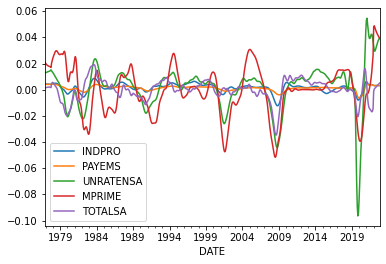

In [15]:
df_diff_sel.drop(labels=['Class'],axis=1).plot()

array([[<AxesSubplot:title={'center':'INDPRO'}>,
        <AxesSubplot:title={'center':'PAYEMS'}>],
       [<AxesSubplot:title={'center':'UNRATENSA'}>,
        <AxesSubplot:title={'center':'MPRIME'}>],
       [<AxesSubplot:title={'center':'TOTALSA'}>,
        <AxesSubplot:title={'center':'Class'}>]], dtype=object)

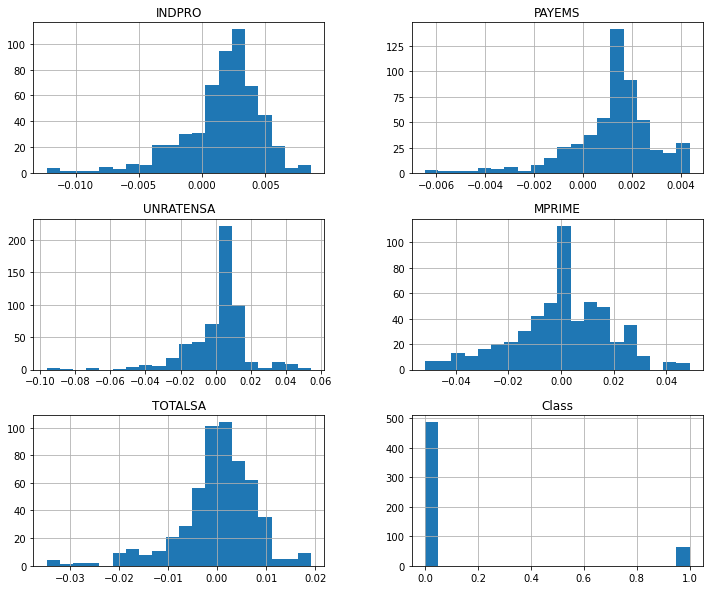

In [16]:
df_diff_sel.hist(figsize=[12,10], bins=20)

In [17]:
df_diff_sel.to_csv("../data/USA_DATA_DIFF.csv")